In [38]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

import plotly.express as px
from datetime import datetime
from dateutil.relativedelta import *
from prophet import Prophet
from sklearn import preprocessing
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

import itertools
from typing import List

## Load trained Prophet model

In [21]:
import pickle

with open("model_prophet.pkl", 'rb') as f:
    model = pickle.load(f)


## Generate future dataframe of 1 day

In [14]:
future_pd = model.make_future_dataframe(
    periods = 24,
    freq = 'h',
    include_history=False
)

## Add additional features

In [ ]:
def get_season(month):
    
    """ 
    Adding season based on general understanding since we aren't aware of which city this data is from.
    For the ease, months from June to October are denoted as 'summer' and months from November to May 
    as 'winter'. 
    
    """
    if month in [6,7,8,9,10]:
        return "0"
    else:
        return "1"
 
def get_time_based_features(df):

    df['year'] = df.dates.dt.year
    df['month'] = df.dates.dt.month
    df['day'] = df.dates.dt.day
    df['hour'] = df.dates.dt.hour
    df['weekday_cat'] = df.dates.dt.weekday
    df['season_cat'] = df.dates.dt.month.apply(get_season)
    
    return df

def get_holidays(df):
    
    """ 
    Adding holidays column to indicate whether a day was a holiday assuming this data is from US.
    
    """

    cal = calendar()
    holidays = cal.holidays(start = df['dates'].min(), end = df['dates'].max())
    df['holiday'] = df['dates'].isin(holidays)
    
    # map to 1 & 0
    mapped = {True:1, False:0}
    df.holiday = df.holiday.map(mapped)
    
    return df

def get_working_non_working_days(df):
    
    """ 
    Non-working days include weekends and holidays.
    
    """
    df['non_working_cat'] = df.apply(lambda x: 'non-working' if \
                                    ((x['holiday'] == 1) or (x['weekday'] in [5, 6]))
                                    else 'working', axis = 1)

    return df

In [29]:
future_pd = get_time_based_features(future_pd)
future_pd = get_holidays(future_pd)
future_pd = get_working_non_working_days(future_pd)

future_pd.head()

,ds,year,month,day,hour,weekday,season,holiday,non_working,weekday_cat,season_cat,non_working_cat
0,2018-08-03 01:00:00,2018,8,3,1,4,0,0,1,4,0,1
1,2018-08-03 02:00:00,2018,8,3,2,4,0,0,1,4,0,1
2,2018-08-03 03:00:00,2018,8,3,3,4,0,0,1,4,0,1
3,2018-08-03 04:00:00,2018,8,3,4,4,0,0,1,4,0,1
4,2018-08-03 05:00:00,2018,8,3,5,4,0,0,1,4,0,1


## Generate predictions

In [31]:
# predict over the dataset

predictions_fb = model.predict(future_pd)

In [34]:
predictions_fb[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2018-08-03 01:00:00,"32,602.08","25,615.24","40,431.94"
1,2018-08-03 02:00:00,"31,398.04","24,260.34","38,666.72"
2,2018-08-03 03:00:00,"30,334.83","23,325.87","37,482.86"
3,2018-08-03 04:00:00,"29,901.46","22,805.72","37,221.84"
4,2018-08-03 05:00:00,"30,502.74","23,247.56","38,201.08"
5,2018-08-03 06:00:00,"32,091.60","24,799.32","39,905.69"
6,2018-08-03 07:00:00,"34,138.96","26,459.71","41,573.29"
7,2018-08-03 08:00:00,"35,979.01","28,221.37","43,160.48"
8,2018-08-03 09:00:00,"37,230.28","29,943.66","44,630.43"
9,2018-08-03 10:00:00,"37,941.53","30,184.66","44,836.75"


In [43]:
px.line(predictions_fb, x='ds', y='yhat', 
        labels={'ds': 'Date', 'yhat': 'Power Consumption - MWH'},
        title=f"Forecasted Power Consumption for the next day")

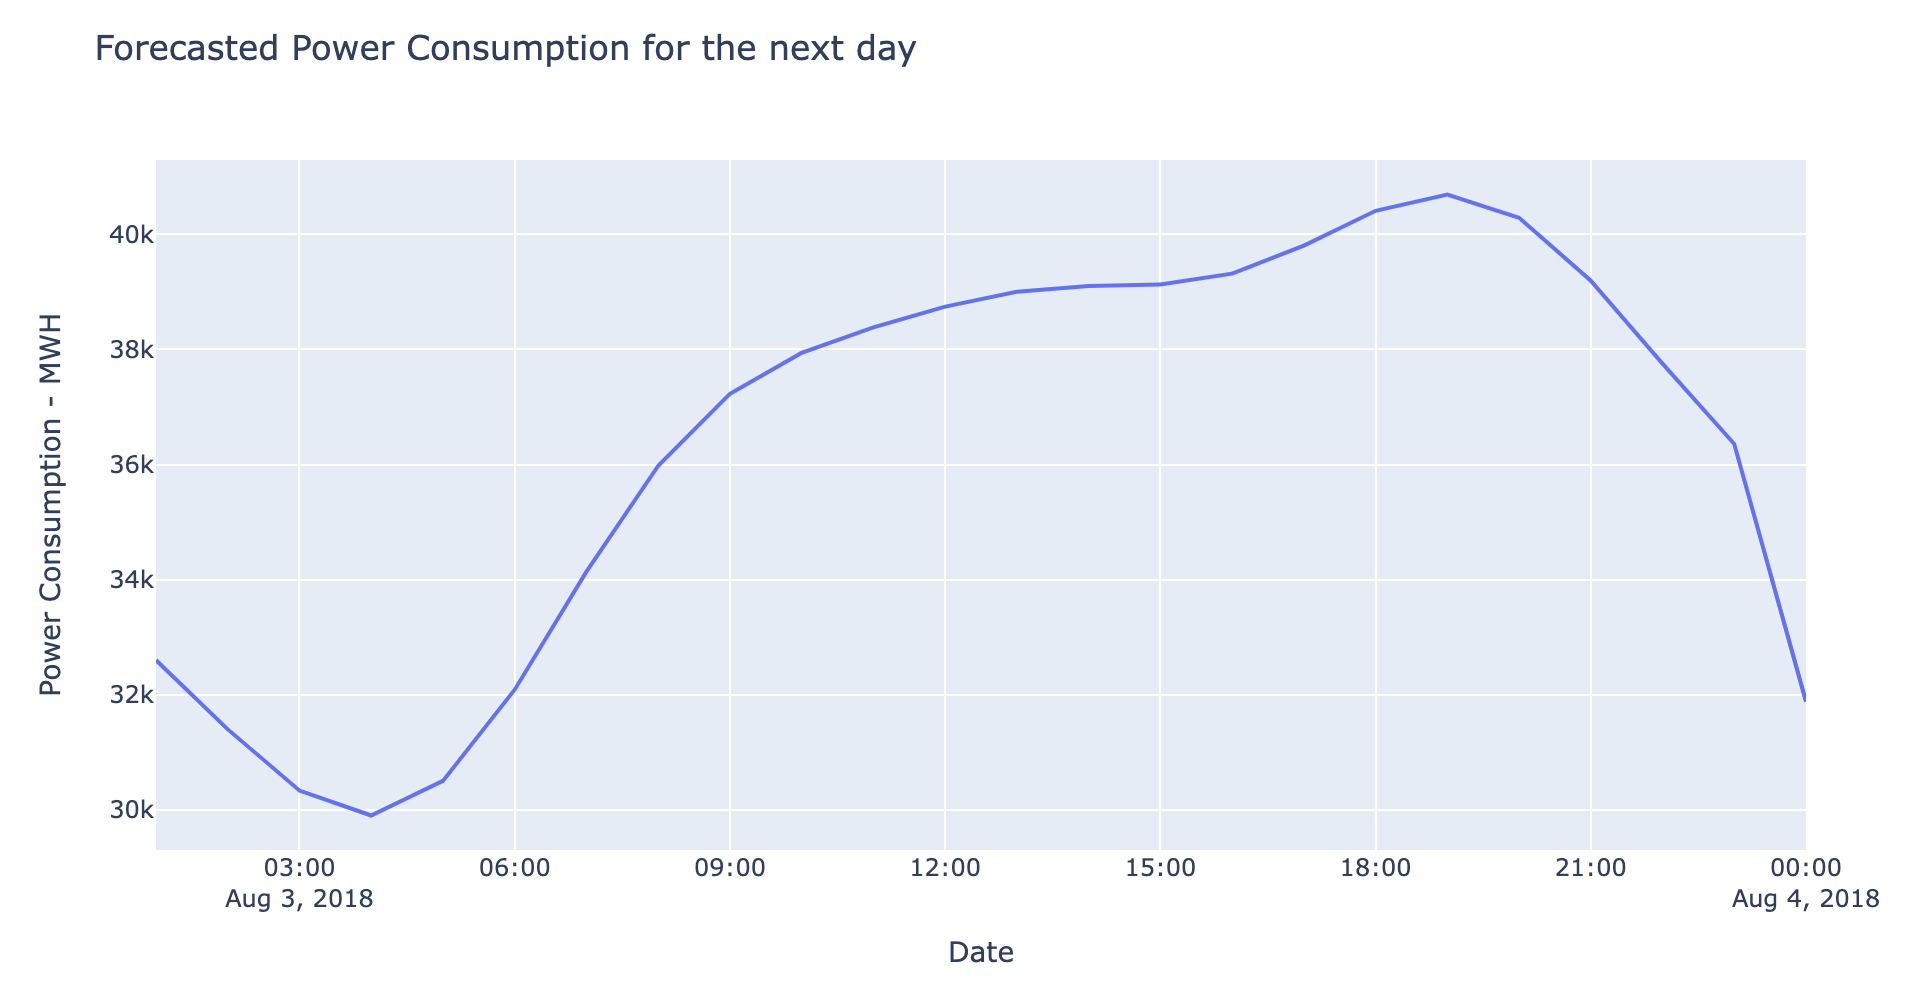

## Conclusion

**The forecasted values for the 1 day in the future seems to also follow a similar trend that we had observed during EDA across years on average that the energy consumption is low in the night, starts to increase in the morning, peaks during the middle of the day, even more so in early evening and starts to die down towards the nigh time. Hence, it feels like the model did a decent job learning from the patterns and signals in the data.**
